# Data Cleaning and EDA

### Import packages and data


In [32]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import recall_score, hamming_loss, f1_score, precision_score 
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes


In [ ]:
#import training data 
df_train = pd.read_csv('../../../data/raw/train_set_values.csv')
df_labels = pd.read_csv('../../../data/raw/train_set_labels.csv')

#merge labels and features:
df_train= pd.merge(df_train, df_labels, on='id')


In [ ]:
#check the target classes counts:
print(df_train.status_group.value_counts())
sns.catplot(x="status_group", kind="count", palette="ch:.25", data=df_train)

Seems like 'functional' and 'non-functional' are almost balanced enough.... but 'functional needs repair' has a big class inbalance. We'll need to address this later at some point in time... maybe through upsampling, or maybe we could just lump it into non-functional. 

### Clean NaN Values

In [ ]:
#find out which features have NAN values. 
df_train.isnull().sum()

There are many features with NaN values. We'll need to address each of these on a case by case basis as far as what we want to do with the empty values. 

In [ ]:
#start with 'scheme_name' since there are so many empty values. 
print(len(df_train.scheme_name.value_counts()))
df_train.scheme_name.value_counts()

In [ ]:
#According to the feature descriptions this is the same
#as scheme_management, so lets check this:
print(len(df_train.scheme_management.value_counts()))
df_train.scheme_management.value_counts()

Ok, scheme_name and scheme_management seem to be different, but because there are over 2669 values for scheme_name and there are 28166 missing values, droping that column will likely not reduce in any loss in predictive power. 

In [ ]:
df_train = df_train.drop('scheme_name', axis=1)

In [ ]:
#functions to aid in data cleaning

def values_to_keep(df, column, number_of_values_to_keep, verbose = False):
    """
    This function takes in a pandas dataframe, the column of concern, and a number of categories to reduce the number 
    of unique values to. It prints the number of unique values in the column and the top value counts of each. It also
    returns a list of categorical values to retain. 
    """
    number_of_values_to_keep = number_of_values_to_keep-1
    
    if verbose == True:
        print(len(df[column].value_counts()))
        print(df[column].value_counts())
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
    else:
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
        
    return list_of_values_to_keep

def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
    """
    This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
    'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
    returns a Dataframe with the altered categorical values. Using this function can reduce the amount of dummy columns
    needed whilst maintaining the information contained in the column.
    """
    #use helper function to create a list of cat. values to keep
    list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
    
    #use subsetting to test if cat. value is in list, if not cast it to 'Other'    "~" means isNOTin 
    df[column_name].loc[~df[column_name].isin(list_of_classes_to_keep)]='Other'
    
    return df

def plot_feature(df, pred_col, target_variable, height = 10):
    
    """
    Produces a categorical bar plot visualizing the number of observations in each target category for each predicitve 
    value. 
    """
    
    sns.catplot(y=pred_col, hue=target_variable, kind="count",
            palette="ch:.25", edgecolor=".6",
            data=df, height= height); 

# def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
#     """
#     This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
#     'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
#     returns a Dataframe with the altered categorical values.
#     """
#     list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
#     for value in df[column_name].unique():
#         if value in list_of_classes_to_keep:
#             pass
#         else:
#             df.loc[df[column_name]== value]="Other"
#     return df


In [ ]:
#ok, now lets check the rest in descending order starting with 'funder':
#Lets find the number of categorical values in 'funder', and the top 10 values:
values_to_keep(df_train, 'funder', 10, verbose=True)

'funder' has 1897 unique categories, ~3000 NaN values, but clearly the majority of the water pumps come from a few of the different funders. it doesnt seem right to just fill the NaNs with the mode. There are also way to many to OneHotEncode. Lets instead turn it into 10 categories: the top 9 frequently occuring values,  and one "other" category which will include all other categories + the NaN values.

In [ ]:
reduce_categorical_values(df_train, 'funder', 10)

In [ ]:
print(len(df_train.funder.value_counts()))
print(df_train.funder.value_counts())
plot_feature(df_train, 'funder', 'status_group')

Looking at the above chart, it seems like funder could be a good predictor sice there are particular funders with significant numbers of disfunctional pumps.  

In [ ]:
#Now for 'installer'.Lets find the number of categorical values in 'installer', and the top 10 values:
values_to_keep(df_train, 'installer', 10, verbose= True)


In [ ]:
#reduce the categorical values of 'installer' to 10, and fill NaN values:
df_train = reduce_categorical_values(df_train, 'installer', 10)

In [ ]:
print(len(df_train.installer.value_counts()))
print(df_train.installer.value_counts())
plot_feature(df_train, 'installer', 'status_group')

Looks like installer could be a useful predictor as well! Look at 'Goverment' and 'RWE'. 

In [ ]:
#Now for 'subvillage'. Lets find the number of categorical values in 'subvillage', and the top 10 values:
values_to_keep(df_train, 'subvillage', 10, verbose= True)

Over 19000 various values! And the top 10 do not seem to have a significant amount of the total distribution, therfore it is highly unlikely that any one of these is great predictor, but just in case lets check the distribution of the top 10. 

In [ ]:
reduce_categorical_values(df_train, 'subvillage', 10)
print(len(df_train.subvillage.value_counts()))
print(df_train.subvillage.value_counts())
plot_feature(df_train, 'subvillage', 'status_group')

Because none of the top 10 villages (not counting 'other') have an overwhelming majority of functioning/nonfunctioning this confirms the previous assumption, the subvillage value is likely to be a poor predictor so we can just drop it.  

In [ ]:
df_train = df_train.drop('subvillage', axis=1)

In [ ]:
#Now for 'public_meeting'. Lets find the number of categorical values in 'public_meeting'.
values_to_keep(df_train, 'public_meeting', 10, verbose= True)

In [ ]:
#Replace NaN values with "Unknown" and visualize the predictor's distribution
df_train.public_meeting.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'public_meeting', 'status_group', height=5)

In [ ]:
#Now for 'scheme_management'. Lets find the number of categorical values in 'scheme_management'.
values_to_keep(df_train, 'scheme_management', 10, verbose= True)

In [ ]:
plot_feature(df_train, 'scheme_management', 'status_group')

Because the 10th most frequent value has mostly "non-functioning" wells, it could be a specific and precise predictor. Lets keep it. So, we'll reduce the number of values to 11, and fill in the ~3000 NaN values. 

In [ ]:

reduce_categorical_values(df_train, 'scheme_management', 12)
print(len(df_train.scheme_management.value_counts()))
print(df_train.scheme_management.value_counts())
plot_feature(df_train, 'scheme_management', 'status_group')

In [ ]:
#Now for 'permit'. Lets find the number of categorical values in 'permit':
values_to_keep(df_train, 'permit', 10, verbose= True)

In [ ]:
#Another boolean valued category. Let's replace the NaN with 'Unknown'
df_train.permit.fillna(value='Unknown', inplace=True)
plot_feature(df_train, 'permit', 'status_group', height=5)

In [ ]:
df_train.isnull().sum()

Great, no more NaN values. Moving on!


### Choosing which columns to keep/drop:

There are still a lot of features. Let's sort through them and drop the less valuable predictors.

I'll be using some intuition here, as well as the data dictionary provided by Driven Data here :

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list


In [ ]:
df_train.info()

In [ ]:
#id is not likely to be a useful predictor:
df_train = df_train.drop('id', axis=1)

In [ ]:
#amount_tsh appears to be a continuous variable. Lets look at the distribution:
sns.distplot(df_train.amount_tsh, bins = 20)
df_train.amount_tsh.value_counts()


The distribution is very skewed. I think that binning this variable could be a good approach in the future after we get a baseline model since very little flow or flow over a certain threshold could be a goood predictor. 

In [ ]:
#lets check gps_height.  
sns.scatterplot(y="status_group",x="gps_height", data=df_train, alpha=.09)

In [ ]:
sns.distplot(df_train.gps_height);

Looks like there are below sea level values for GPS height, which after a quick google search, appears to be impossible values. We'll cast below sea level values to equal 0. 

In [ ]:
df_train['gps_height'].loc[df_train['gps_height']<0]=0


In [ ]:
#We've already looked at installer when dealing with NaN, but installer '0' probably means 'Other' 
#(someone had to install it, even if it is unknown)
df_train.installer.replace(to_replace = '0', value = 'Other', inplace = True)


In [ ]:
#wpt_name is not likely to be a useful predictor:
df_train = df_train.drop('wpt_name', axis=1)

In [ ]:
#num_private has no definition on the data dictionary, and is mostly 0 (58643), lets look more into it:
df_train.num_private.value_counts()

#It seems intuitive to assume that 0 means the pump is not private, and any other number means that it is private.
#Using this assumption lets categorize the pumps as 0 and 1, public/private. Lets see if this seems to be at all 
#predictive:
df_train['num_private'].loc[df_train['num_private']>0]=1

#plot the num_private data
df_num_private = df_train[df_train['num_private']==1]
sns.catplot(x = 'status_group', kind = 'count', data=df_num_private, palette='ch:.25')

Though it is very small compared to the overall dataset it does seem that private pumps are more likely to be functional, so we'll keep it as a predictor. 

In [ ]:
#lets check population around the well. It is a continious variable, and seems like it could be a contributing predictor
#so we'll include it. We may want to scale it later. 
sns.scatterplot(y="status_group",x="population", data=df_train, alpha=.09)


In [ ]:
sns.distplot(df_train.population, bins = 40);

In [ ]:
#how about recored_by:
values_to_keep(df_train, 'recorded_by', 10, verbose=True)
#All of these pumps were recorded by the same entity, so its a useless predictor, we'll drop it. 
df_train = df_train.drop('recorded_by', axis=1)


In [ ]:
#Construction Year:
df_train.construction_year.value_counts();

Construction_year contains 20709 pumps that the year is recorded as '0'. This is a tricky one to deal with, on one 
hand it would be nice to not have to categorize/bin the years (which we would need to do if we cast '0' as 
unknown), on the other hand it doesnt seem like it makes much sense to fill the '0' values with the mean, median, or mode. 

In [ ]:
#It probably makes most sense to bin the years. Thanks to 
#'https://github.com/mldataanalysis/Water-Pump-Classification/blob/master/Water%20Pump%201%20-%20EDA%20and%20Data%20Cleaning.ipynb'
#for the useful function to bin years. 

def construction_binner(row):
    """
    This function's main purpose is to address the '0' values in construction_year. 0 is am impossible value for 
    year of construction, so it casts '0' as 'unknown'. Because 'unknown' is not a continuous value, this function
    then bins the years into decades. So, the resulting column is categorical data with decade values. 
    
    This function is meant to be used apart of a df.apply(lambda row:) function as follows
    
    df_train['construction_year'] = df_train.apply(lambda row: construction_binner(row), axis=1)

    """
    
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00'
    elif row['construction_year'] >= 2010:
        return '10'
    else:
        return 'unknown'
    
df_train['construction_year'] = df_train.apply(lambda row: construction_binner(row), axis=1)


In [ ]:
#Extraction Type also seems to have 3 redundant colums.
print(df_train.extraction_type.value_counts())
print(df_train.extraction_type_class.value_counts())
print(df_train.extraction_type_group.value_counts())

#lets keep the class, because the more granular categories in the other features are so infrequent it is unlikely to 
#add much more info to the model

df_train = df_train.drop('extraction_type_group', axis=1)
df_train = df_train.drop('extraction_type', axis=1)


In [ ]:
#There are two managment features. Lets choose which to keep, if either:
print(df_train.management.value_counts())
print(df_train.management_group.value_counts())

#lets keep the more granular here:
df_train = df_train.drop('management_group', axis=1)


In [ ]:
#There are two payment features. Lets choose which to keep, if either:
print(df_train.payment.value_counts())
print(df_train.payment_type.value_counts())

#these are totally redundant so we'll drop one. 
df_train = df_train.drop('payment', axis=1)


In [ ]:
#There are two water quality features. Lets choose which to keep, if either:
print(df_train.water_quality.value_counts())
print(df_train.quality_group.value_counts())

#lets choose the less granular to avoid overfitting:
df_train = df_train.drop('water_quality', axis=1)



In [ ]:
#There are two quantity features. Lets choose which to keep, if either:
print(df_train.quantity.value_counts())
print(df_train.quantity_group.value_counts())

#once again totally redundant
df_train = df_train.drop('quantity', axis=1)


In [ ]:
#There are three source features. Lets choose which to keep, if any:
print(df_train.source.value_counts())
print(df_train.source_class.value_counts())
print(df_train.source_type.value_counts())

#lets choose the source_class feature, which is the middle between too general and too granular:
df_train = df_train.drop('source', axis=1)
df_train = df_train.drop('source_type', axis=1)


In [ ]:
#There are two water point features. Lets choose which to keep, if any:
print(df_train.waterpoint_type.value_counts())
print(df_train.waterpoint_type_group.value_counts())

#lets choose the one that does not differentiate between single and multiple communal standpipes:
df_train = df_train.drop('waterpoint_type', axis=1)


### Geographic Features

Now lets look at the geography of the wells and see if we can make use of their predictive power somehow:

Great tutorial on plotting point features with geogpandas here: https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

In [38]:
def map_pumps(df_train):
    """
    This function maps the pumps, with their status, across Tanzania.
    You must install/import the following libraries:
    
        import geopandas as gpd
        from shapely.geometry import Point, Polygon
        import matplotlib.pyplot as plt
        import descartes
    """
                  
    #import a Tanzania shape files
    tanz_base = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm0_20181019.shp')
    regions = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm1_20181019.shp')
    ward = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm2_20181019.shp')
    county = gpd.read_file('../../../data/raw/geographic/tza_admbnda_adm3_20181019.shp')

    #set the WGS84 projection
    crs = {'init':'espg:4326'}

    #create geometric points for projecting
    geometry = [Point(xy) for xy in zip( df_train['longitude'], df_train['latitude'])]
    geo_df_train = gpd.GeoDataFrame(df_train, crs = crs, geometry = geometry)
    df_train = df_train.drop('geometry', axis=1)

    #remove geographic outliers/NaNs for visualization clarity 
    #(there were ~1800 points with longitude = 0 (Earlier test-mapping showed this))
    geo_df_train = geo_df_train[geo_df_train.longitude != 0]

    #plot the points over the Tanz base map
    fig,ax = plt.subplots(figsize = (25,25))
    # tanz_base.plot(ax = ax, alpha = .4, color = 'grey')
    ward.plot(ax=ax, color = 'grey', alpha = .4, linewidth=1, edgecolor = 'black')
    geo_df_train[geo_df_train['status_group']=='functional'].plot(ax = ax, markersize = 10, 
                                                                  color = 'blue', alpha = .1, marker = 'o', 
                                                                  label = 'functional')
    geo_df_train[geo_df_train['status_group']=='non functional'].plot(ax = ax, markersize = 10, 
                                                                      color = 'red', alpha = .1, marker = '^', 
                                                                      label = 'non functional')
    geo_df_train[geo_df_train['status_group']=='functional needs repair'].plot(ax = ax, markersize = 10,
                                                                               color = 'yellow', alpha = .1, marker = '*', 
                                                                               label = 'functional needs repair')
    plt.legend(prop = {'size':15})
    

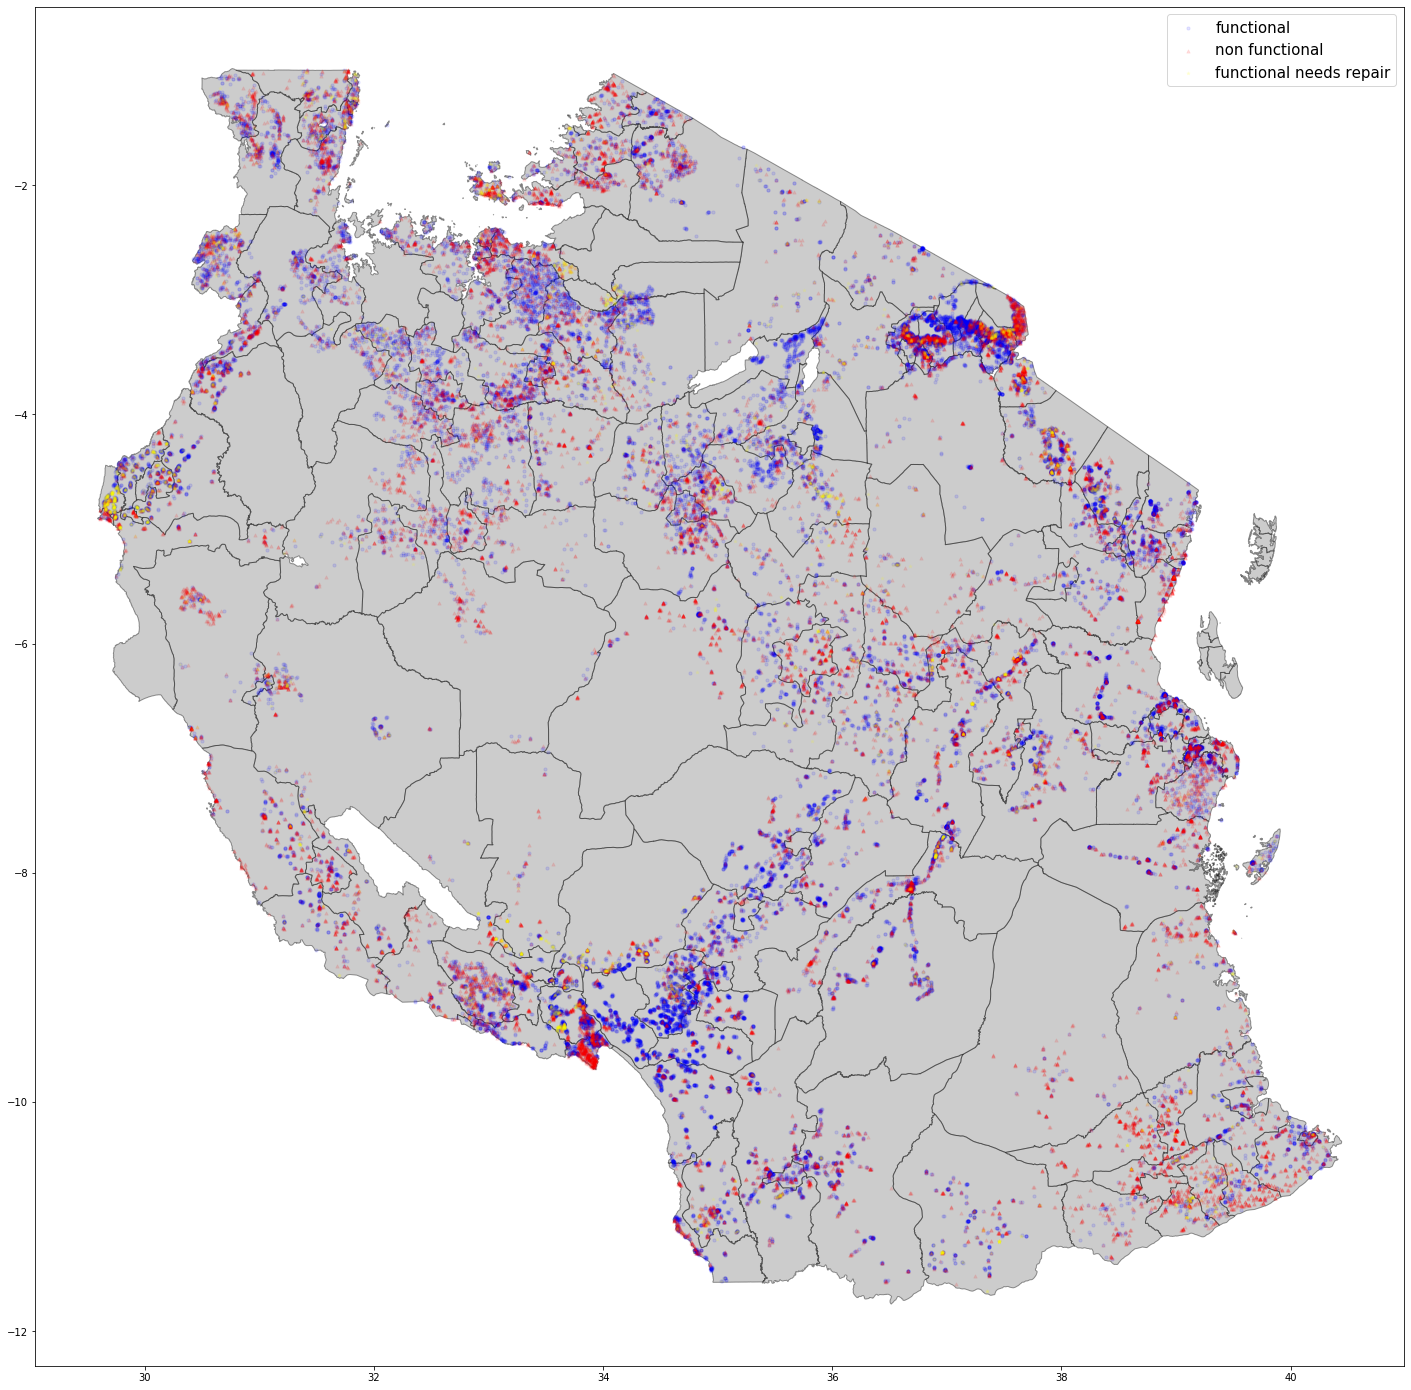

In [42]:
map_pumps(df_train)

There does look to be a possible geographic clustering. For example, in the southern part of the country there are several obvious clusters of red, and in the center of the country blue seems to dominate. They likey correlate most with population distribution, however there could be something else here such as distance from a big city. Using the other geographic features in the dataset may account for these types of correlations, however this could be something to expolore later. If we have time this could be a good stretch goal.

In [43]:
#investigate the other geographical features:

print(df_train.region.value_counts())
print(df_train.region_code.value_counts())
print(df_train.district_code.value_counts())
print(df_train.lga.value_counts())
print(df_train.ward.value_counts())





Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64
11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62

At this time, lets drop Lat, Long, ward, district, region_code, and lga; and we'll keep region.



In [ ]:
df_train = df_train.drop(['lga', 'ward', 'district_code','region_code','latitude', 'longitude'], axis=1)


### Datetime


In [ ]:
df_train.date_recorded.describe()

In [ ]:
#Lets tranform date_recorded into a continuous variable with some sort of potential, such as days since the earliest recordgin

#convert to datetime
df_train.date_recorded = pd.to_datetime(df_train.date_recorded)

#subtract the minimum (oldest date) to get days since first recording
df_train['days_since']=df_train.date_recorded-df_train.date_recorded.min()

#days_since is timedelta64[ns] so we cast it to int64 and dived it by # of ns in day:
df_train['days_since']=df_train['days_since'].astype(int)/(8.64e+13)

#drop date_recorded:
df_train = df_train.drop('date_recorded', axis=1)


### Functionalize the above cleaning:

In [36]:
def import_pump_data():
    #import training data 
    df_train = pd.read_csv('../../../data/raw/train_set_values.csv')
    df_labels = pd.read_csv('../../../data/raw/train_set_labels.csv')
    

    #merge labels and features:
    df_train= pd.merge(df_train, df_labels, on='id')
    
    return df_train

def values_to_keep(df, column, number_of_values_to_keep, verbose = False):
    """
    This function takes in a pandas dataframe, the column of concern, and a number of categories to reduce the number 
    of unique values to. It prints the number of unique values in the column and the top value counts of each. It also
    returns a list of categorical values to retain. 
    """
    number_of_values_to_keep = number_of_values_to_keep-1
    
    if verbose == True:
        print(len(df[column].value_counts()))
        print(df[column].value_counts())
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
    else:
        
        list_of_values = df[column].value_counts()
        list_of_values_to_keep = list(list_of_values[0:number_of_values_to_keep].index)
        
    return list_of_values_to_keep


def reduce_categorical_values(df, column_name, number_of_values_to_keep):
    
    """
    This function reduces the number of unique categorical values in a specific dataframe's column. It keeps the top 
    'number_of_values_to_keep' values, and casts the other remaining categorical values as "Other". This function 
    returns a Dataframe with the altered categorical values. Using this function can reduce the amount of dummy columns
    needed whilst maintaining the information contained in the column.
    """
    #use helper function to create a list of cat. values to keep
    list_of_classes_to_keep = values_to_keep(df, column_name, number_of_values_to_keep)
    
    #use subsetting to test if cat. value is in list, if not cast it to 'Other'    "~" means isNOTin 
    df[column_name].loc[~df[column_name].isin(list_of_classes_to_keep)]='Other'
    
    return df
    

def cols_to_drop():
    """
    This small helper function creates a list of columns to be dropped by future functions.
    
    The columns selected to drop have logic behind the decision. Please see the jupyter notebook:
    ../../notebooks/Exploratory/Brent/Eda_cleaning/ for the detailed logic behind the feature selection. 
    
    """
    cols_to_drop = ['scheme_name','subvillage','id','wpt_name','recorded_by','extraction_type_group',
                    'extraction_type','management_group','payment','water_quality','quantity','source','source_type',
                   'waterpoint_type', 'lga', 'ward', 'district_code','region_code','latitude', 'longitude']
    return cols_to_drop


def drop_features(df, list_of_columns):
    """
    This function drops columns included in list_of_columns
    """
    
    df = df.drop(list_of_columns, axis =1)
    return df

def simplify_categorical_features(df):
    """
    This function simplifies all of the features that have many categorical values in preperation for OneHotEncoding,
    and in the process also cleans up some NaN values.
    
    Each feature's simplification has logic behind it. Please see the jupyter notebook:
    ../../notebooks/Exploratory/Brent/Eda_cleaning/ for the detailed logic behind the simplification.
    """
    
    df = reduce_categorical_values(df, 'funder', 10)
    df = reduce_categorical_values(df, 'installer', 10)
    df = reduce_categorical_values(df, 'scheme_management', 12)
    return df

def construction_binner(row):
    """
    This function's main purpose is to address the '0' values in construction_year. 0 is am impossible value for 
    year of construction, so it casts '0' as 'unknown'. Because 'unknown' is not a continuous value, this function
    then bins the years into decades. So, the resulting column is categorical data with decade values. 
    
    This function is meant to be used apart of a df.apply(lambda row:) function as follows
    
    df_train['construction_year'] = df_train.apply(lambda row: construction_binner(row), axis=1)

    """
    
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00'
    elif row['construction_year'] >= 2010:
        return '10'
    else:
        return 'unknown'

def fill_nans(df):
    """
    This function cleans up NaN values that still remain, and adjusts impossible values, and categorizes the private 
    well feature. 
    
    Each feature's NaN value imputation has logic behind it. Please see the jupyter notebook:
    ../../notebooks/Exploratory/Brent/Eda_cleaning/ for the detailed logic behind the imputation.
    """
    df.public_meeting.fillna(value='Unknown', inplace=True)
    df.permit.fillna(value='Unknown', inplace=True)
    df.installer.replace(to_replace = '0', value = 'Other', inplace = True)
                  
    #account for the impossible year of construction values using contruction_binner function
    df['construction_year'] = df.apply(lambda i: construction_binner(i), axis=1)

    #categorize private wells as private, or public:
    df['num_private'].loc[df['num_private']>0]=1
     
    #remove impossible values from gps_height
    df_train['gps_height'].loc[df_train['gps_height']<0]=0

    return df

def date_time_transform(df):
    """
    This function transforms the date time features in preperation for modeling.
       
    Please see the jupyter notebook: ../../notebooks/Exploratory/Brent/Eda_cleaning/ 
    for the detailed logic behind the handling of date features.
    """

    df.date_recorded = pd.to_datetime(df.date_recorded)
    df['days_since']=df.date_recorded-df.date_recorded.min()
    df['days_since']=df['days_since'].astype(int)/(8.64e+13)
    df = df.drop('date_recorded', axis=1)
    return df
                  


Now, combine the above helper functions into one larger cleaning data function:


In [37]:
def clean_all_data(df):
    """
    This function utilizes the helper functions to complete all of the cleaning.
    """
    
    list_of_columns = cols_to_drop()
    df = drop_features(df, list_of_columns)
    df = simplify_categorical_features(df)
    df = fill_nans(df)
    cleaned_df = date_time_transform(df)
    return cleaned_df

In [41]:
df_train = import_pump_data()

In [30]:
df_train = clean_all_data(df_train)

In [31]:
df_train.shape

(59400, 20)

### Turn the above functions into a pipeline and pickle it:


In [ ]:
data_prep_mapper = Pipeline(steps=[
    ("clean data", clean_all_data(import_pump_data()),
    ("impute", impute_mapper)
])

### OneHotEncode categorical variables:

In [ ]:
target = df_train.status_group
df_train = dum_df.drop('status_group', axis=1)

cat_feats = ['funder','installer', 'num_private',
       'region','public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management',
       'payment_type', 'quality_group', 'quantity_group', 'source_class',
       'waterpoint_type_group']

dum_df = pd.get_dummies(df_train, columns = cat_feats)

X_train, X_test, y_train, y_test = train_test_split(dum_df, target)


In [ ]:
dum_df.head()

### Test a basic model

In [ ]:
def model_GridSearch(X_train, X_test, y_train, y_test):
    
    best_params = {'learning_rate': [0.075, 0.7],
                      'max_depth': [13, 14],
                      'min_samples_leaf': [15, 16],
                      'max_features': [1.0],
                      'n_estimators': [100, 200]}                     

    estimator = GridSearchCV(estimator=GradientBoostingClassifier(),
                             param_grid=best_params,
                             n_jobs=-1)

    estimator.fit(X_train, y_train)

    best_params = estimator.best_params_

    print (best_params)

    validation_accuracy = estimator.score(X_test, y_test)
    print('Validation accuracy: ', validation_accuracy)

In [ ]:
def best_GBC_model(X_train, X_test, y_train, y_test):
    
    best_params = {'learning_rate': [0.075],
                        'max_depth': [14],
                        'min_samples_leaf': [16],
                        'max_features': [1.0],
                        'n_estimators': [100]}                     

    estimator = GridSearchCV(estimator=GradientBoostingClassifier(),
                             param_grid=best_params,
                             n_jobs=-1)

    estimator.fit(X_train, y_train)

    best_params = estimator.best_params_

    print (best_params)

    validation_accuracy = estimator.score(X_test, y_test)
    print('Validation accuracy: ', validation_accuracy)

In [ ]:
model(X_train, X_test, y_train, y_test)

In [ ]:
def get_score(model, X_train, y_train, y_train_hat):
    rec = recall_score(y_train, y_train_hat, average = 'weighted')
    hamming = hamming_loss(y_train, y_train_hat)
    f1 = f1_score(y_train, y_train_hat, average = 'weighted')
    prec = precision_score(y_train, y_train_hat, average = 'weighted')
    acc = model.score(X_train, y_train)
    print(f"""
        Recall Score: {rec} 
        Hamming Loss: {hamming} 
        f1 Score: {f1} 
        Precision Score: {prec}
        Accuracy: {acc}""")

In [ ]:
bt2 = BaggingClassifier(max_features=0.6, max_samples= 0.4,
 n_estimators= 200)

bt2.fit(X_train, y_train)

y_train_pred_bt2 = bt2.predict(X_train)

get_score(bt2, X_train, y_train, y_train_pred_bt2)

In [ ]:
bt2_cv_score = cross_val_score(bt2, X_train, y_train, cv=7)
mean_bt2_cv_score = np.mean(bt2_cv_score)
print(f"Mean Cross Validation Best Param Score: {mean_bt2_cv_score :.2%}")



In [ ]:
xg2 = XGBClassifier(learning_rate = 0.01, 
    max_depth = 30, 
    n_estimators= 200)
xg2.fit(X_train, y_train)
y_train_pred_xg2 = xg2.predict(X_train)
get_score(xg2, X_train, y_train, y_train_pred_xg2)
# xg_cv_score = cross_val_score(xg, X_train_min_ohe, y_train, cv=7)
# mean_xg_cv_score = np.mean(xg_cv_score)
# xg2_cv_score = cross_val_score(xg2, X_train_min_ohe, y_train, cv=7)
# mean_xg2_cv_score = np.mean(xg2_cv_score)
# print(f"Mean Cross Validation Score: {mean_xg_cv_score :.2%}")
# print(f"Mean Cross Validation Best Param Score: {mean_xg2_cv_score :.2%}")

In [ ]:
#parses df for categorical variables
def make_ohe(input_df: pd.DataFrame, cat_var) -> pd.DataFrame:
    """One Hot Encodes categorical variables"""
    # Load necessary data
    cat_df = input_df[cat_var]
    # Create OHE object
    ohe = OneHotEncoder(categories = 'auto', drop = 'first').fit(cat_df)
    # Create OHE DataFrame
    ohe_df = pd.DataFrame(ohe.transform(cat_df).toarray(), 
                          columns=ohe.get_feature_names(cat_var))
    return ohe_df

In [ ]:
# df_train = df_train.drop('status_group', axis = 1)
cat_feats = ['funder','installer', 'num_private',
       'region','public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management',
       'payment_type', 'quality_group', 'quantity_group', 'source_class',
       'waterpoint_type_group']


In [ ]:
df_ohe = make_ohe(df_train, cat_feats)

In [ ]:
ohe = OneHotEncoder(drop='first')
ohe.fit(df_cat)
ohe_df = ohe.transform(df_cat)
ohe_df = pd.DataFrame(ohe_df, columns=ohe.get_feature_names(['funder','region']))

In [ ]:
ohe